In [52]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Load the Excel file
data_path = '/content/drive/MyDrive/Statistical_Modeling/AIGC_data_v2.xlsx'
aigc_data = pd.read_excel(data_path)

# Display the first few rows and the data types of each column
aigc_data.head(), aigc_data.dtypes


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(   Year  Num_of_Large_Models_with_1_Billion+Parameters  AIGC_Market_Size  \
 0  2017                                              0               0.1   
 1  2018                                              0               0.2   
 2  2019                                              0               0.3   
 3  2020                                              2               0.5   
 4  2021                                             32               1.0   
 
    AI_Journal_Publications  AI_Journal_Citations  AI_Conference_Publications  \
 0                     50.0                 27.17                       19.16   
 1                     65.0                 30.17                       21.97   
 2                     84.0                 31.77                       25.90   
 3                    101.0                 30.27                       22.52   
 4                    117.0                 29.07                       22.25   
 
    AI_Conference_Citations  AI_Repository_Publi

In [53]:
# Check for missing values in the key columns
missing_values_check = aigc_data[["Num_of_Large_Models_with_1_Billion+Parameters", "AIGC_Market_Size"]].isnull().sum()

# Get basic statistics for potential outliers or unusual data
statistical_summary = aigc_data[["Num_of_Large_Models_with_1_Billion+Parameters", "AIGC_Market_Size"]].describe()

missing_values_check, statistical_summary

(Num_of_Large_Models_with_1_Billion+Parameters    0
 AIGC_Market_Size                                 0
 dtype: int64,
        Num_of_Large_Models_with_1_Billion+Parameters  AIGC_Market_Size
 count                                       7.000000          7.000000
 mean                                       24.714286         24.300000
 std                                        33.149732         53.138122
 min                                         0.000000          0.100000
 25%                                         0.000000          0.250000
 50%                                         2.000000          0.500000
 75%                                        46.000000         13.000000
 max                                        79.000000        143.000000)

In [54]:
import numpy as np

# 1. Normalization (using min-max normalization)
normalized_data = (aigc_data[["Num_of_Large_Models_with_1_Billion+Parameters", "AIGC_Market_Size"]] - aigc_data[["Num_of_Large_Models_with_1_Billion+Parameters", "AIGC_Market_Size"]].min()) / \
                  (aigc_data[["Num_of_Large_Models_with_1_Billion+Parameters", "AIGC_Market_Size"]].max() - aigc_data[["Num_of_Large_Models_with_1_Billion+Parameters", "AIGC_Market_Size"]].min())

# 2. Calculate Proportions
proportions = normalized_data / normalized_data.sum()

# 3. Compute Entropy
entropy = -np.sum(proportions * np.log(proportions + np.finfo(float).eps), axis=0) / np.log(len(aigc_data))

# 4. Calculate Redundancy (1 - Entropy)
redundancy = 1 - entropy

# 5. Calculate Weights
weights = redundancy / redundancy.sum()

# 6. Compute Development Level Score
development_score = (normalized_data * weights).sum(axis=1)

weights, development_score


(Num_of_Large_Models_with_1_Billion+Parameters    0.3689
 AIGC_Market_Size                                 0.6311
 dtype: float64,
 0    0.000000
 1    0.000442
 2    0.000883
 3    0.011106
 4    0.153403
 5    0.390145
 6    1.000000
 dtype: float64)

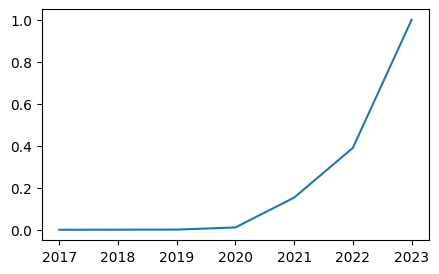

In [55]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize= (5,3))
x = aigc_data["Year"]
y = development_score
plt.plot(x, y)
plt.xticks(x)
plt.show()

In [56]:
# Select the additional indicators from the dataset excluding the previously used columns
additional_indicators = aigc_data.drop(columns=["Year", "Num_of_Large_Models_with_1_Billion+Parameters", "AIGC_Market_Size"])

# Check for missing values in the selected indicators
missing_values_additional = additional_indicators.isnull().sum()

# Get basic statistics for potential outliers or unusual data
statistical_summary_additional = additional_indicators.describe()

missing_values_additional, statistical_summary_additional


(AI_Journal_Publications                                                      0
 AI_Journal_Citations                                                         0
 AI_Conference_Publications                                                   0
 AI_Conference_Citations                                                      0
 AI_Repository_Publications                                                   0
 AI_Repository_Citations                                                      0
 GitHub_AI_projects                                                           0
 GitHub_Stars                                                                 0
 National_Basic_Computing_Power                                               0
 National_Supercomputing_Power                                                0
 National_Intelligent_Computing_Power                                         0
 Num_of_Enterprises_Software&Information_Technology_Services_Industry         0
 Revenue_Software&Information_Technology

In [57]:
# Normalize the additional indicators using min-max normalization
normalized_additional = (additional_indicators - additional_indicators.min()) / \
                        (additional_indicators.max() - additional_indicators.min())

# Calculate Proportions for entropy calculations
proportions_additional = normalized_additional / normalized_additional.sum()

# Compute Entropy for each variable
entropy_additional = -np.sum(proportions_additional * np.log(proportions_additional + np.finfo(float).eps), axis=0) / np.log(len(additional_indicators))

# Calculate Redundancy (1 - Entropy)
redundancy_additional = 1 - entropy_additional

# Calculate Weights for each indicator
weights_additional = redundancy_additional / redundancy_additional.sum()

# Compute Development Potential Score by summing weighted scores for each year
development_potential_score = (normalized_additional * weights_additional).sum(axis=1)

weights_additional, development_potential_score


(AI_Journal_Publications                                                      0.050019
 AI_Journal_Citations                                                         0.032440
 AI_Conference_Publications                                                   0.036102
 AI_Conference_Citations                                                      0.040062
 AI_Repository_Publications                                                   0.050285
 AI_Repository_Citations                                                      0.056363
 GitHub_AI_projects                                                           0.063983
 GitHub_Stars                                                                 0.038332
 National_Basic_Computing_Power                                               0.059026
 National_Supercomputing_Power                                                0.069461
 National_Intelligent_Computing_Power                                         0.081921
 Num_of_Enterprises_Software&Information_Te

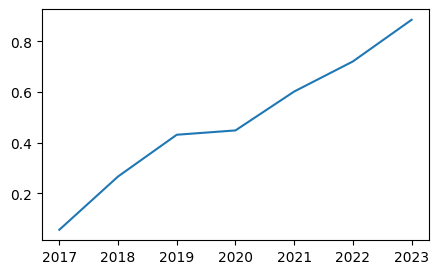

In [58]:

fig = plt.figure(figsize= (5,3))
x = aigc_data["Year"]
y = development_potential_score
plt.plot(x, y)
plt.xticks(x)
plt.show()

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the dataset for modeling
# Using the normalized_additional dataframe which contains all the additional indicators normalized
# 'development_potential_score' is our target variable
X = normalized_additional
y = development_score

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on the testing set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Feature Importance
feature_importance = rf_regressor.feature_importances_

mse, r2, feature_importance


(0.007993618385481138,
 -163934.05347200052,
 array([0.03419202, 0.019022  , 0.01048064, 0.02534648, 0.01221756,
        0.0491212 , 0.15636537, 0.03816065, 0.04339225, 0.10698768,
        0.05431298, 0.05498441, 0.03118832, 0.06834721, 0.02167844,
        0.07626614, 0.04573067, 0.07338645, 0.02228471, 0.05653481]))

In [60]:
X

,AI_Journal_Publications,AI_Journal_Citations,AI_Conference_Publications,AI_Conference_Citations,AI_Repository_Publications,AI_Repository_Citations,GitHub_AI_projects,GitHub_Stars,National_Basic_Computing_Power,National_Supercomputing_Power,National_Intelligent_Computing_Power,Num_of_Enterprises_Software&Information_Technology_Services_Industry,Revenue_Software&Information_Technology_Services_Industry,Num_of_Employees_Software&Information_Technology_Services_Industry,Fixed_Assets_Investment_Software&Information_Technology_Services_Industry,R&D_Funding_Software&Information_Technology_Services_Industry,Num_of_Newly_Funded_AI Companies,Private_Investment_in_AI,Num_of_Internet_Users,Internet_Penetration
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.576803,0.000000,0.000000,0.000,0.000000,0.592350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.147929,0.652174,0.416914,0.300055,0.127090,0.084384,1.000000,0.256654,0.119266,0.125,0.015825,0.711562,0.131658,0.195029,0.135396,0.093666,0.664706,0.456790,0.178125,0.175115
2,0.335306,1.000000,1.000000,0.441899,0.363434,0.349284,0.764890,0.503802,0.247706,0.250,0.202310,0.789180,0.273866,0.462290,0.270793,0.248574,0.747059,0.456790,0.412500,0.400922
3,0.502959,0.673913,0.498516,0.455537,0.561873,0.433668,0.200627,0.627376,0.348624,0.250,0.242087,1.000000,0.434219,0.425416,0.176982,0.439007,0.594118,0.598765,0.678125,0.672811
4,0.660750,0.413043,0.458457,0.698309,0.707915,0.686819,0.153605,0.712928,0.522936,0.250,0.455945,0.000000,0.661505,0.655389,1.000000,0.639878,1.000000,1.000000,0.812500,0.792627
5,0.832347,0.802174,0.774332,0.844790,0.853958,0.827708,0.224138,0.750951,0.761468,0.750,0.757057,0.548527,0.862204,0.863838,0.447775,0.870358,0.411765,0.413580,0.921875,0.912442
6,1.000000,0.886957,0.874184,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000,1.000000,0.392638,1.000000,1.000000,0.812379,1.000000,0.860784,0.871605,1.000000,1.000000


In [61]:
# Initialize and train the Random Forest regressor using all available data
rf_regressor_full = RandomForestRegressor(n_estimators=100, random_state=2)
rf_regressor_full.fit(X, y)

# Feature Importance from the model trained on all data
feature_importance_full = rf_regressor_full.feature_importances_

# Organize feature importance for better understanding
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance_full
}).sort_values(by='Importance', ascending=False)

features_df


,Feature,Importance
15,R&D_Funding_Software&Information_Technology_Se...,0.087806
6,GitHub_AI_projects,0.082432
7,GitHub_Stars,0.077140
18,Num_of_Internet_Users,0.075973
12,Revenue_Software&Information_Technology_Servic...,0.069896
10,National_Intelligent_Computing_Power,0.065867
8,National_Basic_Computing_Power,0.065349
9,National_Supercomputing_Power,0.062251
11,Num_of_Enterprises_Software&Information_Techno...,0.060735
5,AI_Repository_Citations,0.053492


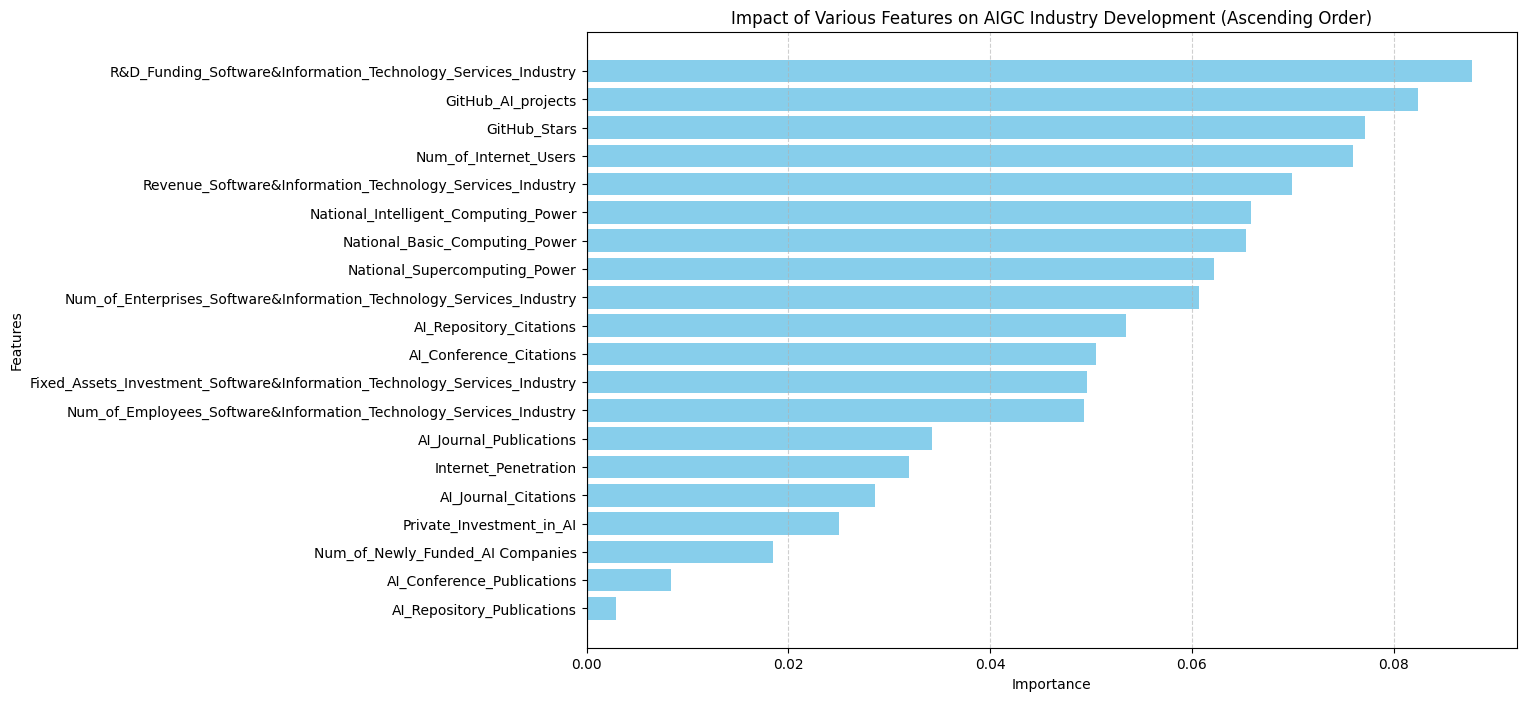

In [62]:
import matplotlib.pyplot as plt
# Create a bar chart for the coefficients in ascending order
plt.figure(figsize=(12, 8))
sorted_features_df = features_df.sort_values(by='Importance', ascending=True)
plt.barh(sorted_features_df['Feature'], sorted_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Impact of Various Features on AIGC Industry Development (Ascending Order)')
plt.axvline(x=0, color='grey', linewidth=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [63]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score

# Define the models
models = {
    "Multiple Linear Regression": LinearRegression(),
    "Lasso": Lasso(random_state=42),
    "Ridge": Ridge(random_state=42),
    "Elastic Net": ElasticNet(random_state=42)
}

# Evaluate each model using cross-validation and collect performance metrics
results = {}
for name, model in models.items():
    # Cross-validated R^2 score
    cv_r2 = cross_val_score(model, X, development_score, cv=3, scoring='r2').mean()
    # Cross-validated Mean Squared Error (MSE)
    cv_mse = -cross_val_score(model, X, development_score, cv=3, scoring='neg_mean_squared_error').mean()

    results[name] = {'CV R^2 Score': cv_r2, 'CV MSE': cv_mse}

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
results_df


,CV R^2 Score,CV MSE
Multiple Linear Regression,-1.992901e+06,0.575695
Lasso,-3.863694e+05,0.241770
Ridge,-3.323614e+05,0.231336
Elastic Net,-3.863694e+05,0.241770


In [64]:
# Train the Multiple Linear Regression model on all available data
mlr_model = LinearRegression()
mlr_model.fit(X, y)

# For future predictions, we will assume the indicators grow at the same average rate as the last few years
# Calculate the average annual growth rate for each feature
growth_rates = (X.iloc[-1] - X.iloc[0]) / len(X)

# Simulate future data for the next 3 years based on these growth rates
future_data = pd.DataFrame([X.iloc[-1] + (i + 1) * growth_rates for i in range(3)], index=[2024, 2025, 2026])

# Make predictions using the trained model
future_predictions = mlr_model.predict(future_data)

future_data, future_predictions


(      AI_Journal_Publications  AI_Journal_Citations  \
 2024                 1.142857              1.013665   
 2025                 1.285714              1.140373   
 2026                 1.428571              1.267081   
 
       AI_Conference_Publications  AI_Conference_Citations  \
 2024                    0.999067                 1.142857   
 2025                    1.123951                 1.285714   
 2026                    1.248834                 1.428571   
 
       AI_Repository_Publications  AI_Repository_Citations  GitHub_AI_projects  \
 2024                    1.142857                 1.142857           -0.082400   
 2025                    1.285714                 1.285714           -0.164801   
 2026                    1.428571                 1.428571           -0.247201   
 
       GitHub_Stars  National_Basic_Computing_Power  \
 2024      1.142857                        1.142857   
 2025      1.285714                        1.285714   
 2026      1.428571          

In [65]:
# Extract coefficients from the Multiple Linear Regression model
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': mlr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

# Display the coefficients
coefficients

,Feature,Coefficient
9,National_Supercomputing_Power,0.909413
10,National_Intelligent_Computing_Power,0.592913
8,National_Basic_Computing_Power,0.456405
17,Private_Investment_in_AI,0.252467
16,Num_of_Newly_Funded_AI Companies,0.191441
11,Num_of_Enterprises_Software&Information_Techno...,0.119950
7,GitHub_Stars,0.099938
14,Fixed_Assets_Investment_Software&Information_T...,0.066788
0,AI_Journal_Publications,-0.004927
5,AI_Repository_Citations,-0.018230
